In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as io
import matplotlib.pyplot as plt
from keras import utils as np_utils
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.stats
import sklearn.metrics
import h5py
from keras.callbacks import EarlyStopping
from keras import models, layers, optimizers, backend, constraints, activations, losses
import complexnn
import TIMBRE.helpers as helpers

In [2]:
#redefine TIMBRE function with legacy Adam optimizer so it will run on Mac

def TIMBRE(X, Y, inds_test, inds_train, hidden_nodes=0, learn_rate=.001, is_categorical=True, verbosity=0, save_path=None, filename=None):
    """
    Learns oscillatory patterns that are predictive of class labels

    Parameters:
    - X = Multi-channel data (T samples x N channels, complex-valued)
    - Y = Category labels (T samples, integer-valued)
    - inds_test = test indices (Either T x 1 boolean, or U x 1 integers)
    - inds_train = train indices (Either T x 1 boolean, or U x 1 integers)
    - hidden_nodes = how many nodes to use (no hidden layer if set to 0)
    - learn_rate = how quickly the network learns
    - is_categorical = whether the output consists of discrete classes
    - verbosity = amount of model training info to output (default = 0)

    Returns:
    - model: trained network
    - fittedModel: history of loss and accuracy for test and train data
    - test_acc: accuracy on test data after training
    """

    # stack the real and imaginary components of the data
    X = np.concatenate((np.real(X), np.imag(X)), axis=1)
    # use one-hot encoding for the class labels
    if is_categorical:
        Y = np_utils.to_categorical(Y)
        my_loss = 'categorical_crossentropy'
    else:
        my_loss = 'kde'
    backend.clear_session()
    # Early Stopping: stop training model when test loss stops decreasing
    es = EarlyStopping(monitor='val_loss', patience=1)
    # Specify the algorithm and step size used by gradient descent
    adam = optimizers.legacy.Adam(learning_rate=learn_rate)
    if hidden_nodes > 0:
        num_chans = hidden_nodes
    else:
        num_chans = Y.shape[1]
    model = models.Sequential()
    # Layer 1: Takes a complex-valued projection of the input
    model.add(complexnn.dense.ComplexDense(num_chans, input_shape=(X.shape[1],), use_bias=False,
                                           kernel_constraint=constraints.unit_norm()))
    # Layer 2: Converts complex-valued output of layer 0 to a real-valued magnitude
    model.add(layers.Lambda(lambda x: (x[:, :x.shape[1] // 2] ** 2 + x[:, x.shape[1] // 2:] ** 2) ** .5))
    # Layer 3: Softmax of layer 2
    model.add(layers.Activation(activations.softmax))
    if hidden_nodes > 0:  # Need another layer for output
        model.add(layers.Dense(Y.shape[1], activation='softmax'))
    model.compile(loss=my_loss, optimizer=adam, metrics=['accuracy'])
    # Train the model
    fittedModel = model.fit(X[inds_train, :], Y[inds_train, :], epochs=100,
                            verbose=0, validation_data=(X[inds_test, :], Y[inds_test, :]),
                            shuffle=True, callbacks=[es])
    test_acc = fittedModel.history['val_accuracy'][-1]
    
        #Save trained model (addition from original TIMBRE function)
    if filename:
        from keras.models import save_model
        save_model(model, filename + ".h5")
        
    return model, fittedModel, test_acc

In [3]:
def band_whiten(X, inds_train, u, Xv):
    X = X @ np.conj(u.T)
    X = X / Xv
    return X

In [4]:
def filter(matrix, range_low, range_high, btype='bp', fs = 1250/25, order = 3, use_hilbert = True):
    #Bandpass filter for specific broadbands 
    #TIMBRE filter function will not work for bandpass filters!
    nyq = 0.5*fs
    normal_range_low = range_low / nyq
    normal_range_high = range_high / nyq
    b, a = signal.butter(order, [normal_range_low, normal_range_high], btype=btype, analog=False)
    filt_X = signal.filtfilt(b, a, matrix, axis=0)
    return filt_X 

In [74]:
data = io.loadmat('data01.mat') #load drudged data to train models
lapID = data['lapID']
theta_preHilbert = filter(data['lfps'], range_low = 6, range_high = 12, btype= 'bp',order= 2) 
harm_preHilbert = filter(data['lfps'], range_low = 14, range_high = 20, btype= 'bp',order= 2)

theta_LFPs = signal.hilbert(theta_preHilbert, axis= 0)
harm_LFPs = signal.hilbert(harm_preHilbert, axis= 0)
double_LFPs = np.abs(theta_LFPs)*np.exp(np.angle(theta_LFPs)*2*1j)

In [75]:
inds_test, inds_train = helpers.test_train(lapID, 1, n_folds=5, which_fold=0)

In [84]:
full_LFPs = helpers.filter_data(data['lfps'], 2, fs=1250/25, use_hilbert=True)

w_full, u, Xv = helpers.whiten(full_LFPs, inds_train)
w_theta = band_whiten(theta_LFPs, inds_train, u, Xv)
w_harm = band_whiten(harm_LFPs, inds_train, u, Xv)
w_double = band_whiten(double_LFPs, inds_train, u, Xv)

#w_double = np.abs(w_theta)*np.exp(np.angle(w_theta)*2*1j) #to double after whitening

test_theta = np.concatenate((np.real(w_theta), np.imag(w_theta)), axis=1)
test_harm = np.concatenate((np.real(w_harm), np.imag(w_harm)), axis=1)
test_double = np.concatenate((np.real(w_double), np.imag(w_double)), axis=1)

In [85]:
theta_phases = np.imag(w_theta)
harm_phases = np.imag(w_harm)
double_phases = np.imag(w_double)

In [102]:
theta_model, theta_fittedModel, theta_test_acc = TIMBRE(w_theta, lapID[:, 1], inds_test, inds_train, hidden_nodes=0, save_path="", filename=f"theta_model_1")

harm_model, harm_fittedModel, harm_test_acc = TIMBRE(w_harm, lapID[:, 1], inds_test, inds_train, hidden_nodes=0, save_path="", filename=f"harm_model_1")

double_model, double_fittedModel, double_test_acc = TIMBRE(w_double, lapID[:, 1], inds_test, inds_train, hidden_nodes=0, save_path="", filename=f"double_model_1")

/var/folders/9p/9b3pkj717gzd6mtq0_87y1ww0000gn/T/ipykernel_1072/946004348.py:60: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, filename + ".h5")


In [103]:
theta_weights = np.array(theta_model.get_weights())[0,:,:] + 1j * np.array(theta_model.get_weights())[1,:,:]
harm_weights = np.array(harm_model.get_weights())[0,:,:] + 1j * np.array(harm_model.get_weights())[1,:,:]
double_weights = np.array(double_model.get_weights())[0,:,:] + 1j * np.array(double_model.get_weights())[1,:,:]

In [104]:
double_weights.shape

(255, 3)

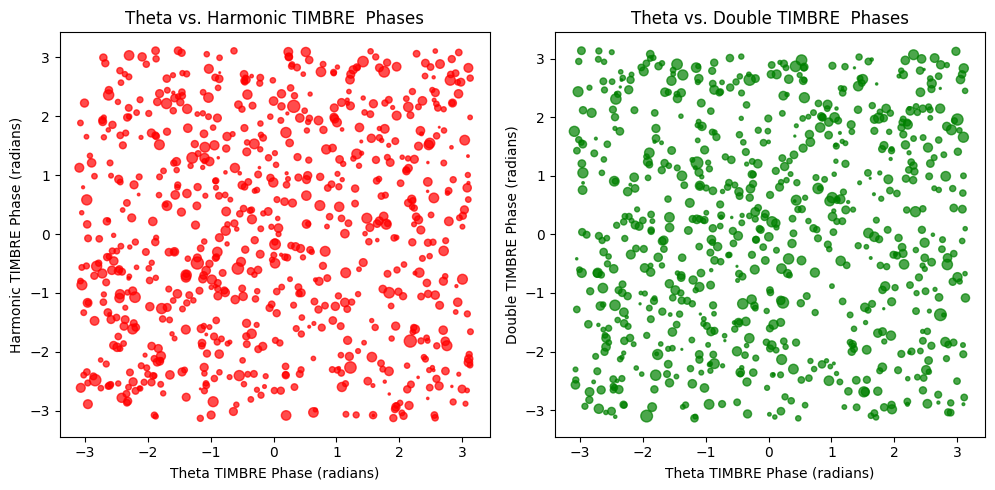

In [106]:
# Create the figure for the third component of the filter
plt.figure(figsize=(15, 5))

# Theta vs. Harmonic CSP Phase
plt.subplot(1, 3, 1)
plt.scatter(np.angle(theta_weights[:,:]), np.angle(harm_weights[:,:]), color='r', alpha=0.7, sizes = (np.abs(harm_weights[:,0])*300))
#plt.scatter(np.angle(theta_weights[:,1]), np.angle(harm_weights[:,1]), color='g', alpha=0.7, sizes = (np.abs(theta_weights[:,1])*300))

plt.xlabel("Theta TIMBRE Phase (radians)")
plt.ylabel("Harmonic TIMBRE Phase (radians)")
plt.title("Theta vs. Harmonic TIMBRE  Phases")

# Theta vs. Double CSP Phase
plt.subplot(1, 3, 2)
plt.scatter(np.angle(theta_weights[:,:]), np.angle(double_weights[:,:]), color='g', alpha=0.7, sizes = (np.abs(double_weights[:,0])*300))
#plt.scatter(np.angle(theta_weights[:,1]), np.angle(harm_weights[:,1]), color='g', alpha=0.7, sizes = (np.abs(theta_weights[:,1])*300))

plt.xlabel("Theta TIMBRE Phase (radians)")
plt.ylabel("Double TIMBRE Phase (radians)")
plt.title("Theta vs. Double TIMBRE  Phases")

#plt.plot(theta_phase, theta_phase, color='black', linestyle='--', linewidth=1)  # Diagonal reference line

# Adjust layout and show the plots
plt.tight_layout()
plt.show()